In [22]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 
import numpy as np
from tensorflow import keras
from keras import layers,models

In [2]:
BATCH_SIZE = 16
IMG_HEIGHT = 109
IMG_WIDTH = 89
EPOCHS = 2
RGB = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = "D:\Dr_Strange\DataSets\Project_DATA\MaleFemale\GenderClasses",
    batch_size = BATCH_SIZE,
    shuffle = True,
    image_size = (IMG_WIDTH,IMG_HEIGHT)
    
)

Found 202599 files belonging to 2 classes.


In [4]:
dataset.class_names

['Female', 'Male']

In [5]:
len(dataset)
# 3166*64
# one Batch consist of 3166 datasamples

12663

In [6]:
def data_partition(ds,train_split = 0.8,test_split = 0.1, val_split = 0.1,shuffle = True,shuffle_size = 10000):
    train_size = int(len(ds)*train_split)
    test_size = int(len(ds)*test_split)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 12)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(test_size)
    test_ds = ds.skip(train_size).skip(test_size)
    
    return  train_ds,val_ds,test_ds

In [7]:
train_ds,val_ds,test_ds = data_partition(dataset)

In [8]:
len(train_ds),len(val_ds),len(test_ds)

(10130, 1266, 1267)

In [ ]:
# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
# val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
# test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [9]:
resize_nd_rescale = keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_WIDTH,IMG_HEIGHT),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [10]:
augmentation = keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
input_shape = (BATCH_SIZE,IMG_WIDTH,IMG_HEIGHT,RGB)
op_classes = len(dataset.class_names)
model = models.Sequential([
    resize_nd_rescale,
    augmentation,
    layers.Conv2D(32,(3,3),activation = 'relu',input_shape = input_shape ),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu' ),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu' ),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(op_classes,activation = 'softmax')
])
model.build(input_shape = input_shape)

In [12]:
model.compile(
    optimizer = 'adam',
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (16, 89, 109, 3)          0         
_________________________________________________________________
sequential_1 (Sequential)    (16, 89, 109, 3)          0         
_________________________________________________________________
conv2d (Conv2D)              (16, 87, 107, 32)         896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (16, 43, 53, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (16, 41, 51, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (16, 20, 25, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (16, 18, 23, 64)         

In [14]:
performance = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    verbose = 1,
    epochs = EPOCHS
#     validation_data = val_ds
    
)

Epoch 1/2
10130/10130 [==============================] - 1209s 102ms/step - loss: 0.2932 - accuracy: 0.8713
Epoch 2/2
10130/10130 [==============================] - 1296s 107ms/step - loss: 0.1985 - accuracy: 0.9189


In [17]:
performance.history.keys()

dict_keys(['loss', 'accuracy'])

In [20]:
performance.history['accuracy']

[0.8713465332984924, 0.918868899345398]

Actual Label:  Male
Model Prediction:  Male


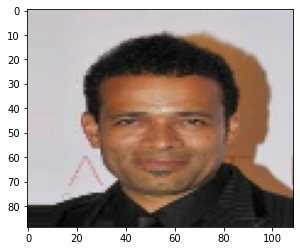

In [23]:
for img_batch,label_batch in test_ds.take(1):
    first_img =  img_batch[0].numpy().astype("uint8")
    first_label = label_batch[0]
    
    plt.imshow(first_img)
    print("Actual Label: ",dataset.class_names[first_label])
    predicted_label = model.predict(img_batch)
    print("Model Prediction: ",dataset.class_names[np.argmax(predicted_label[0])])

In [26]:
class_names = dataset.class_names
class_names

['Female', 'Male']

In [27]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    predicted_label = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_label,confidence

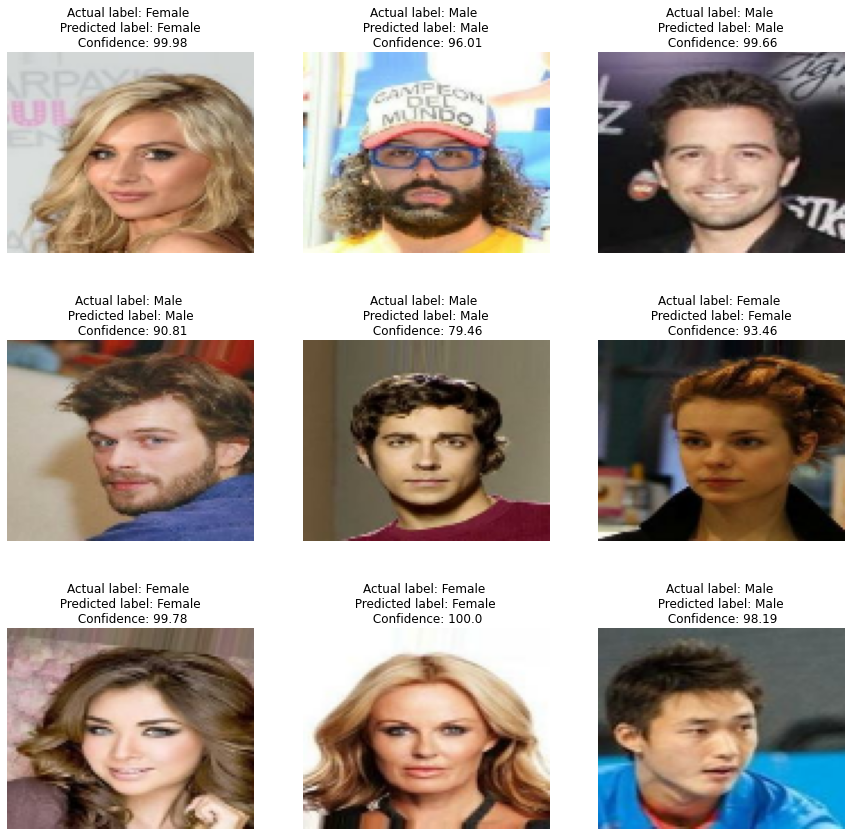

In [28]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_label,confidence = predict(model,images[i])
        actual_label = dataset.class_names[labels[i]]
        plt.axis('off')
        plt.title(f"Actual label: {actual_label} \n Predicted label: {predicted_label} \n Confidence: {confidence}")
    